In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np

import pandas as pd
import random as rn
import glob # to find files
import cv2

# Chart
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from skimage import color, exposure
from sklearn.metrics import classification_report

# Seaborn library for bar chart
import seaborn as sns

# Libraries for TensorFlow

import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

print("All required library Imported")

All required library Imported


**Loading the data**

In [ ]:
data_path = '../content/drive/MyDrive/Project_pneumonia_detection/chest_xray/'

#data_path

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

Resize the image to **200x200**

In [ ]:
img_size = 200

In [ ]:
#Function for reading data from folders.


def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images  #Returns numpy array [img, label]
  

Exploring dataset

In [ ]:
train = read_data([train_path])
test = read_data([val_path, test_path])


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


test dataset contains val and test folders

In [ ]:
#Shuffling the data
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

**Creating dataframe for data visualisation**


In [ ]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])


In [ ]:
train_df['label'].head()

0    PNEUMONIA
1       NORMAL
2       NORMAL
3       NORMAL
4    PNEUMONIA
Name: label, dtype: object

**Data Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


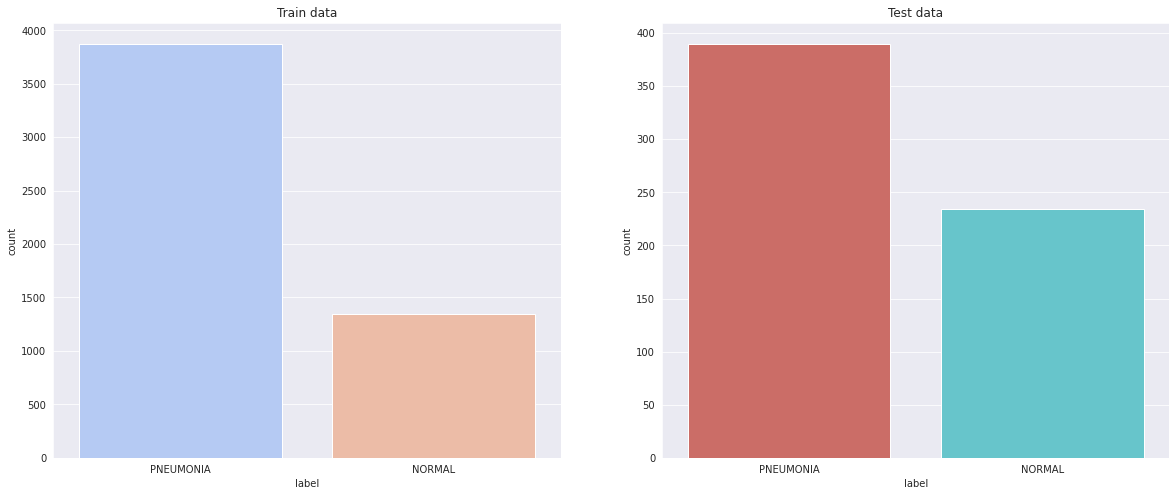

In [ ]:
plt.figure(figsize=(20, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

Here, We can see in the data distribution all the size are not same in distributions, but it is similar in the test and training data.

**Let's see the Images**

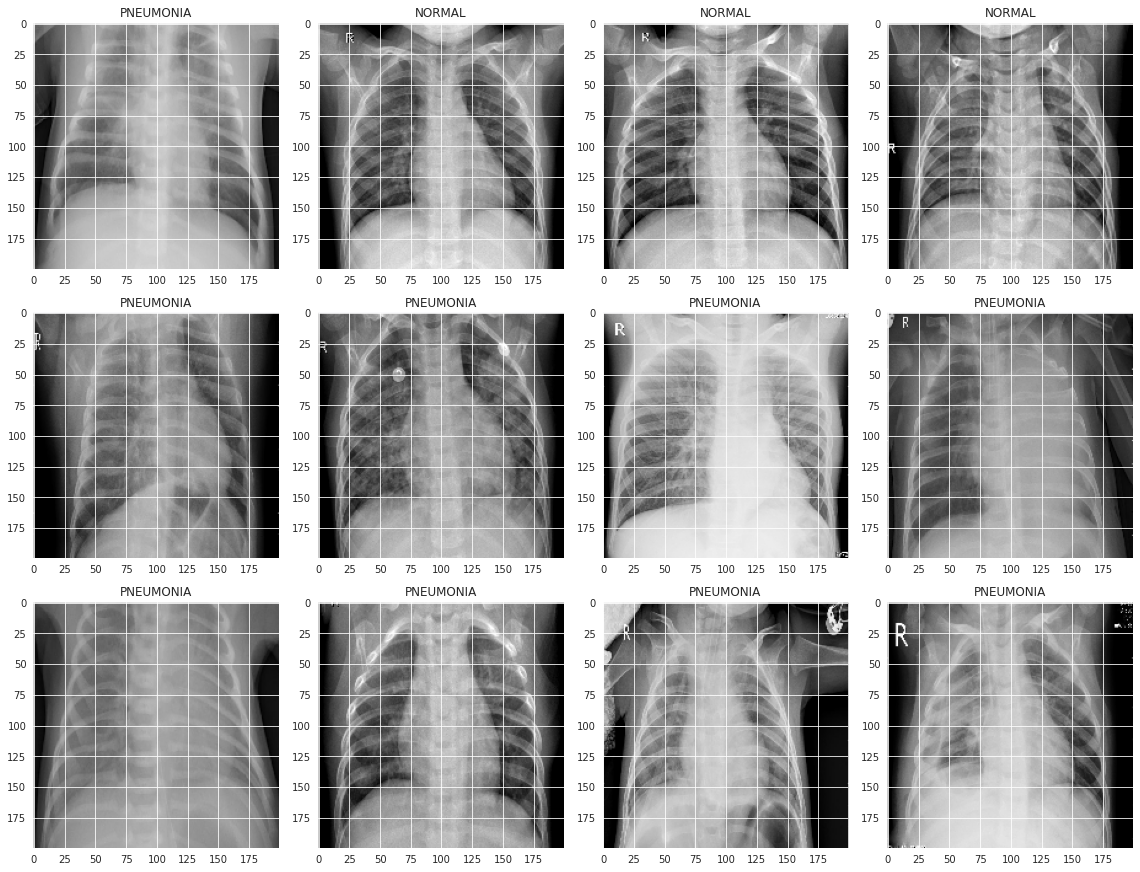

In [ ]:
def Show_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(12):
        plt.subplot(4, 4, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_image()

**Now we will preprocess the Data**

In [95]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

**Splitting the Data**

In [96]:
def splitdata(data): #splitdata function is for spliting the data into X and Y arrays
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [97]:
# Now we are shuffling the data 
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

**Data preparing for CNN**

In [98]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [99]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [100]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

**Now we are converting images to Grayscale, normalize and table reshaping function**

In [101]:
# images to Grayscale conversion
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    
    return data1

In [102]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [103]:
num_classes = y_train.shape[1]

In [104]:
input_shape = (img_size, img_size, 1)

In [105]:
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [106]:
num_pixels 

200

**First model CNN**

In [ ]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='sigmoid'),
        Dropout(0.5),
        
        Dense(256, activation='sigmoid'),
        Dropout(0.5),
        
        Dense(64, activation='sigmoid'), # All above were relu
        Dropout(0.5),
        Dense(num_classes*2, activation = "softmax"), #or sigmoid
        Reshape((2,2))
        
    ])

In [ ]:
model = get_modelcnn()
# model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      9

**Fitting the model**

In [ ]:
learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 20,
          verbose = 1,
          callbacks = callbacks1,
          validation_data = (X_test, y_test))

Epoch 1/20
82/82 [==============================] - 59s 318ms/step - loss: 0.6368 - accuracy: 0.8281 - val_loss: 1.2109 - val_accuracy: 0.6250
Epoch 2/20
82/82 [==============================] - 23s 278ms/step - loss: 0.4666 - accuracy: 0.9454 - val_loss: 0.9984 - val_accuracy: 0.6250
Epoch 3/20
82/82 [==============================] - 23s 278ms/step - loss: 0.4335 - accuracy: 0.9584 - val_loss: 1.2790 - val_accuracy: 0.6250
Epoch 4/20
82/82 [==============================] - 23s 276ms/step - loss: 0.4197 - accuracy: 0.9618 - val_loss: 1.4955 - val_accuracy: 0.6250
Epoch 5/20
82/82 [==============================] - 23s 277ms/step - loss: 0.4070 - accuracy: 0.9688 - val_loss: 1.5995 - val_accuracy: 0.3750
Epoch 6/20
82/82 [==============================] - 23s 277ms/step - loss: 0.4076 - accuracy: 0.9688 - val_loss: 0.6695 - val_accuracy: 0.7596
Epoch 7/20
82/82 [==============================] - 22s 274ms/step - loss: 0.4035 - accuracy: 0.9716 - val_loss: 1.7272 - val_accuracy: 0.6250

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 214.52538967132568%
Test accuracy: 62.5%
MLP Error: 37.50%


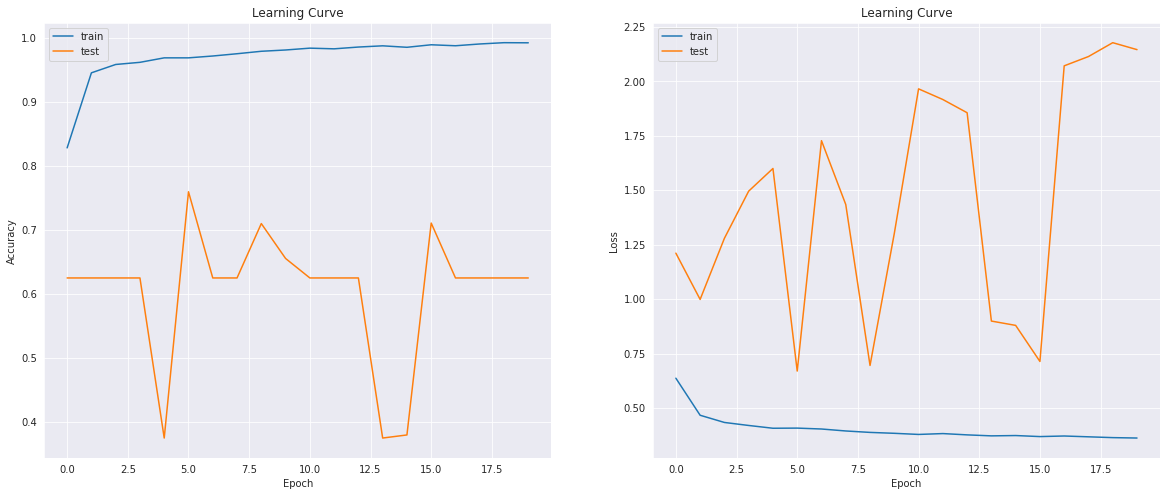

In [ ]:
draw_learning_curve(learning_history)

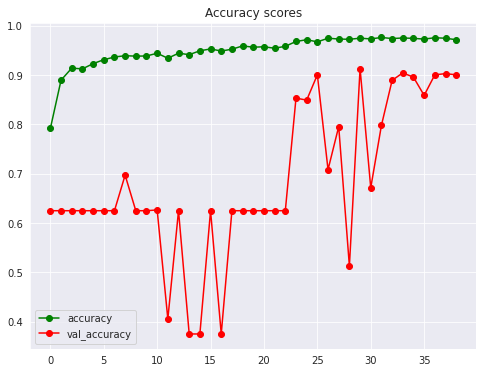

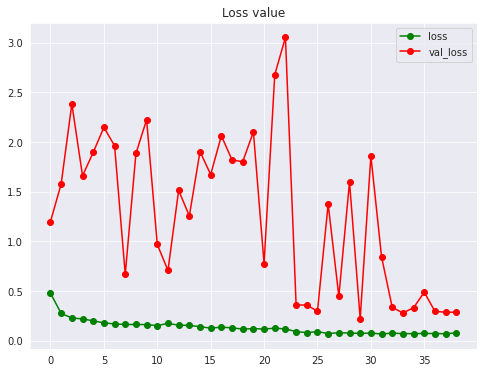

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(learning_history.history['accuracy'],'go-')
plt.plot(learning_history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(learning_history.history['loss'],'go-')
plt.plot(learning_history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

In [107]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [108]:
callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

**Second model CNN**

In [109]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='sigmoid'), # earlier relu
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='sigmoid'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes*2, activation = "softmax"),
        Reshape((2,2))
        
        
    ])

In [110]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 200, 200, 16)      2320      
_________________________________________________________________
batch_normalization_72 (Batc (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 100, 100, 32)     

In [111]:
learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks2,
                        )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
163/163 [==============================] - 31s 174ms/step - loss: 0.4968 - accuracy: 0.7849 - val_loss: 0.8260 - val_accuracy: 0.6250
Epoch 2/100
163/163 [==============================] - 28s 170ms/step - loss: 0.2823 - accuracy: 0.8859 - val_loss: 1.6001 - val_accuracy: 0.6250
Epoch 3/100
163/163 [==============================] - 28s 169ms/step - loss: 0.2299 - accuracy: 0.9142 - val_loss: 0.8383 - val_accuracy: 0.6250
Epoch 4/100
163/163 [==============================] - 28s 169ms/step - loss: 0.2035 - accuracy: 0.9243 - val_loss: 2.1168 - val_accuracy: 0.6250
Epoch 5/100
163/163 [==============================] - 27s 168ms/step - loss: 0.1992 - accuracy: 0.9258 - val_loss: 1.8724 - val_accuracy: 0.6250
Epoch 6/100
163/163 [==============================] - 27s 168ms/step - loss: 0.1753 - accuracy: 0.9339 - val_loss: 0.9281 - val_accuracy: 0.4463
Epoch 7/100
163/163 [==============================] - 27s 168ms/step - loss: 0.1615 - accuracy: 0.9386 - val_loss: 1.9797 -

In [112]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

Test loss: 22.730785608291626%
Test accuracy: 92.62820482254028%


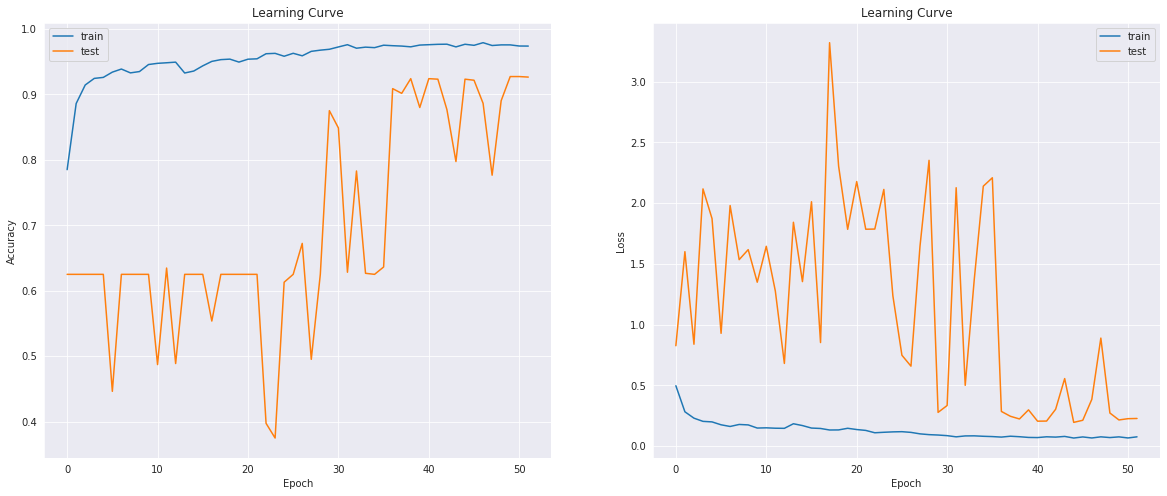

In [128]:
draw_learning_curve(learning_history)

In [118]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [119]:
y_pre_test = np.argmax(y_test, axis = 1)

In [127]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.66      0.79       234
           1       0.92      0.97      0.94       390

   micro avg       0.93      0.85      0.89       624
   macro avg       0.95      0.81      0.86       624
weighted avg       0.94      0.85      0.88       624
 samples avg       0.85      0.85      0.85       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
